In [1]:
install.packages('dplyr')
install.packages('ggplot2')
install.packages('lme4')
install.packages('ggeffects')
install.packages('tidyr')
install.packages('broom')
install.packages('MuMIn')


The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages


In [2]:
library(dplyr)
library(ggplot2)
library(lme4)
library(ggeffects)
library(tidyr)
library(broom)
library(MuMIn)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Registered S3 methods overwritten by 'MuMIn':
  method        from 
  nobs.multinom broom
  nobs.fitdistr broom



In [3]:
vf = read.csv('von_frey_dataset.csv')

# Applying Linear Models to find the one with the best fit 

In [4]:
# standardizing day number for better convergence of the lme models 
vf$DayNumber_z = scale(vf$DayNumber)

In [5]:
# creating multiple models 
m1 = lmer (Force ~ DayNumber_z + (DayNumber_z| ID), data = vf)
m2 = lmer (Force ~ DayNumber_z * Trial + (DayNumber_z |ID), data = vf)

In [6]:
#comparing nested models to find one that fits the data best 
anova(m1,m2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,-2*log(L),Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m1,6,19479.51,19514.10,-9733.755,19467.51,NA,NA,NA
m2,8,19199.42,19245.55,-9591.711,19183.42,284.0891,2,2.045683e-62


Observations- 
- m2 seems to give the best fit of the two models on the basis of its extremely significant p-value (<0.001) and much lower AIC value. 

In [9]:
summary(m2)

Linear mixed model fit by REML ['lmerMod']
Formula: Force ~ DayNumber_z * Trial + (DayNumber_z | ID)
   Data: vf

REML criterion at convergence: 19179

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6076 -0.7496 -0.0673  0.6920  3.8242 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept)  25.846   5.084        
          DayNumber_z   5.898   2.428   -0.74
 Residual             194.662  13.952        
Number of obs: 2358, groups:  ID, 18

Fixed effects:
                   Estimate Std. Error t value
(Intercept)         33.4750     1.3000  25.750
DayNumber_z         -1.7795     0.7343  -2.423
TrialI             -10.0487     0.5904 -17.020
DayNumber_z:TrialI  -1.8118     0.5802  -3.123

Correlation of Fixed Effects:
            (Intr) DyNmb_ TrialI
DayNumber_z -0.497              
TrialI      -0.247  0.011       
DyNmbr_z:TI  0.004 -0.412 -0.019

## Linear model-predicted withdrawal force trajectories 

In [10]:
day_mean = mean(vf$DayNumber, na.rm = TRUE)
day_sd = sd(vf$DayNumber, na.rm = FALSE)

In [11]:
# get model predictions for both sides 
pred = ggpredict(m2, terms = c('DayNumber_z', 'Trial'))

In [12]:
# convert standardized day to day 
pred$DayNumber = pred$x * day_sd + day_mean

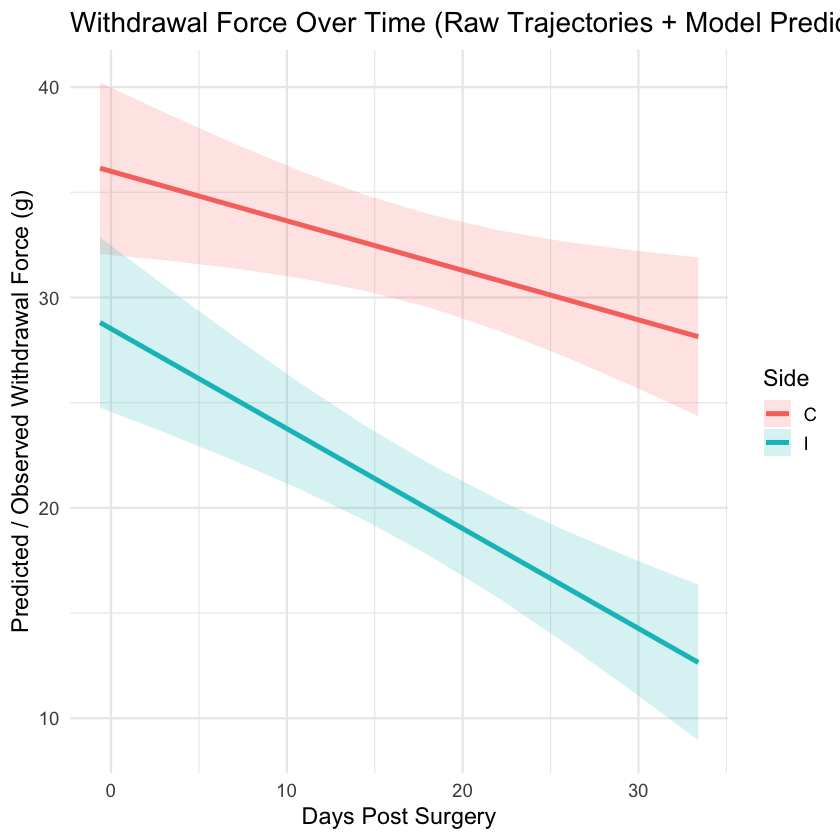

In [13]:
#population-level prediction 
ggplot() +
  # Population CI ribbons
  geom_ribbon(
    data = pred,
    aes(x = DayNumber, ymin = conf.low, ymax = conf.high, fill = group),
    alpha = 0.18, color = NA
  ) +
  # Population lines
  geom_line(
    data = pred,
    aes(x = DayNumber, y = predicted, color = group),
    linewidth = 1.4
  ) +
  labs(
    title = "Withdrawal Force Over Time (Raw Trajectories + Model Predictions)",
    x = "Days Post Surgery",
    y = "Predicted / Observed Withdrawal Force (g)",
    color = "Side",
    fill  = "Side"
  ) +
  theme_minimal(base_size = 14)

In [14]:
#individual trajectories predicted by the model 
ind_preds <- vf %>%
  distinct(ID, Trial) %>%                 # one row per rat per side
  group_by(ID, Trial) %>%
  do({
    DayNumber_z_seq <- seq(min(vf$DayNumber_z, na.rm = TRUE),
                           max(vf$DayNumber_z, na.rm = TRUE),
                           length.out = 100)
    data.frame(
      ID = .$ID[1],
      Trial = .$Trial[1],
      DayNumber_z = DayNumber_z_seq,
      DayNumber   = DayNumber_z_seq * day_sd + day_mean,
      pred = predict(
        m2,
        newdata = data.frame(
          DayNumber_z = DayNumber_z_seq,
          ID = .$ID[1],
          Trial = .$Trial[1]              
        )
        
      )
    )
  }) %>%
  ungroup()

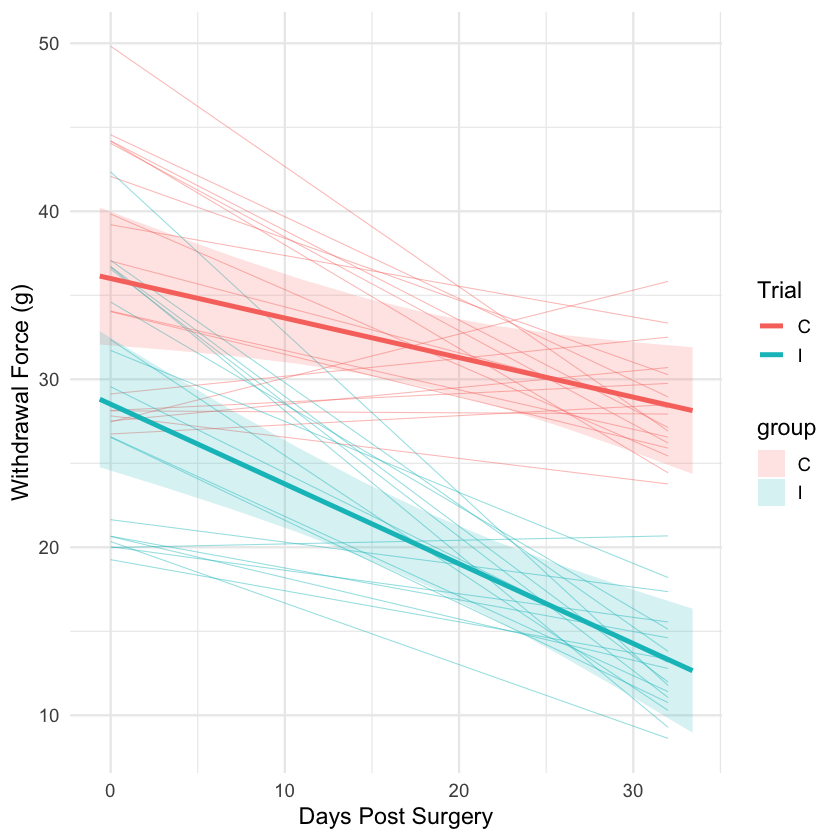

In [15]:

ggplot() +
  geom_line(data = ind_preds,
            aes(x = DayNumber, y = pred,
                group = interaction(ID, Trial), color = Trial),
            alpha = 0.45, linewidth = 0.3) +
# Population CI ribbons
  geom_ribbon(
    data = pred,
    aes(x = DayNumber, ymin = conf.low, ymax = conf.high, fill = group),
    alpha = 0.18, color = NA
  ) +
  # Population lines
  geom_line(
    data = pred,
    aes(x = DayNumber, y = predicted, color = group),
    linewidth = 1.4
  ) +
  labs(x = "Days Post Surgery", y = "Withdrawal Force (g)")+
  theme_minimal(base_size = 14)

In [16]:
r.squaredGLMM(m2)

R2m,R2c
0.1251467,0.247799


- R2m(marginal r squared) ~12.5 %variance explained by fixed effects 
- R2c(conditional r squared) ~24.8 %variance explained by fixed + random effects 

In [17]:
m3 = lmer(
  Force ~ DayNumber_z * Stage + Trial + (DayNumber_z | ID),
  data = vf)

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



In [18]:
summary(m3)
r.squaredGLMM(m3)

Linear mixed model fit by REML ['lmerMod']
Formula: Force ~ DayNumber_z * Stage + Trial + (DayNumber_z | ID)
   Data: vf

REML criterion at convergence: 19106.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7603 -0.7422 -0.0680  0.6802  3.3902 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept)  26.155   5.114        
          DayNumber_z   5.619   2.370   -0.80
 Residual             188.934  13.745        
Number of obs: 2358, groups:  ID, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept)  31.5833     1.3177  23.968
DayNumber_z  -0.5198     0.6915  -0.752
StagePRE      9.8617     1.0834   9.103
TrialI       -9.8196     0.5823 -16.865

Correlation of Fixed Effects:
            (Intr) DyNmb_ StgPRE
DayNumber_z -0.623              
StagePRE    -0.162  0.343       
TrialI      -0.247  0.022  0.051
fit warnings:
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient

R2m,R2c
0.1515269,0.2736662


- R2m(marginal r squared) ~15% variance explained by fixed effects
- R2c(conditional r squared) ~27% variance explained by fixed + random effects

## Applying non-linear models to check for better fit

In [19]:
# use a non-linear term 
vf$DayNumber_z2 = vf$DayNumber_z^2

In [20]:
m4 = lmer(
  Force ~ DayNumber_z + DayNumber_z2 + Stage + Trial +
          DayNumber_z:Stage + DayNumber_z2:Stage +
          (DayNumber_z + Trial | ID),
  data = vf)

fixed-effect model matrix is rank deficient so dropping 2 columns / coefficients



In [21]:
summary(m4)
r.squaredGLMM(m4)

Linear mixed model fit by REML ['lmerMod']
Formula: 
Force ~ DayNumber_z + DayNumber_z2 + Stage + Trial + DayNumber_z:Stage +  
    DayNumber_z2:Stage + (DayNumber_z + Trial | ID)
   Data: vf

REML criterion at convergence: 19019.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1850 -0.7244 -0.0478  0.6974  3.7708 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 ID       (Intercept)  29.952   5.473              
          DayNumber_z   6.546   2.558   -0.74      
          TrialI       34.353   5.861   -0.45  0.07
 Residual             179.734  13.407              
Number of obs: 2358, groups:  ID, 18

Fixed effects:
             Estimate Std. Error t value
(Intercept)   30.6574     1.4258  21.502
DayNumber_z   -1.1846     0.7636  -1.551
DayNumber_z2   0.8550     0.3595   2.378
StagePRE       7.7852     1.3204   5.896
TrialI        -8.7661     1.5513  -5.651

Correlation of Fixed Effects:
            (Intr) DyNmb_ DyNm_2 StgPRE
DayNumber_z -0.497 

R2m,R2c
0.1392014,0.2946344


In [101]:
m5 = lmer(
  Force ~ poly(DayNumber_z, 2, raw=TRUE) * Stage * Trial + (DayNumber_z | ID),
  data = vf)

fixed-effect model matrix is rank deficient so dropping 4 columns / coefficients



In [102]:
summary(m5)
r.squaredGLMM(m5)

Linear mixed model fit by REML ['lmerMod']
Formula: 
Force ~ poly(DayNumber_z, 2, raw = TRUE) * Stage * Trial + (DayNumber_z |  
    ID)
   Data: vf

REML criterion at convergence: 19069.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0169 -0.7426 -0.0591  0.6677  3.2574 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept)  26.440   5.142        
          DayNumber_z   6.511   2.552   -0.76
 Residual             186.429  13.654        
Number of obs: 2358, groups:  ID, 18

Fixed effects:
                                         Estimate Std. Error t value
(Intercept)                               31.0648     1.3880  22.382
poly(DayNumber_z, 2, raw = TRUE)1         -1.4754     0.8989  -1.641
poly(DayNumber_z, 2, raw = TRUE)2          1.5283     0.5054   3.024
StagePRE                                   2.5845     1.9144   1.350
TrialI                                   -10.0252     0.7833 -12.798
poly(DayNumber_z, 2, raw = TRUE)1:TrialI 

R2m,R2c
0.1614909,0.2874238


In [103]:
#comparing two best model
anova(m2,m5)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,-2*log(L),Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m2,8,19199.42,19245.55,-9591.711,19183.42,NA,NA,NA
m5,12,19103.47,19172.65,-9539.733,19079.47,103.9563,4,1.413423e-21


The non linear model seems to have an improved R2m and R2c value as compared to the linear model. The likelihood ratio test showed a highly significant p-value for the non linear model (p<<0.001). Given these improvements, I chose not to pursue further models. 

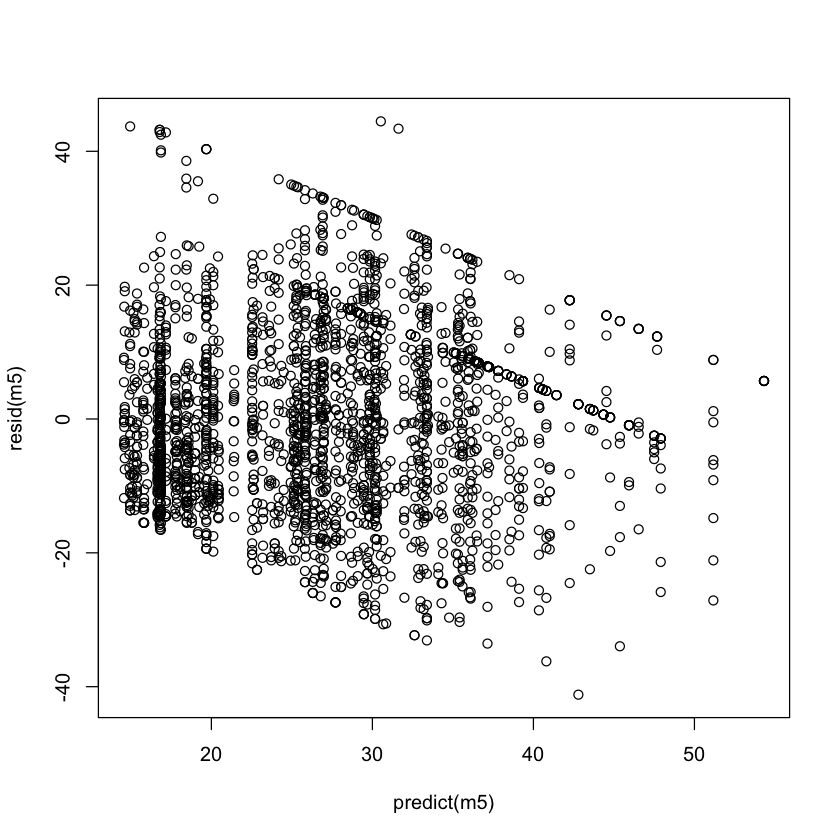

In [104]:
plot(predict(m5), resid(m5))

In [105]:
day_mean = mean(vf$DayNumber, na.rm = TRUE)
day_sd   = sd(vf$DayNumber, na.rm = TRUE)

In [106]:
head(vf)

,Session,Date,Treatment,Protocol,Stage,DayNumber,Trial,ID,Latency,Reason,Scoring,Force,DayNumber_z,DayNumber_z2
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
1,1,2024-03-12 16:21:00,CCD,AMN,PRE,0,C,DW 239,0.9,Detection,Auto,33.81,-1.417452,2.009171
2,2,2024-03-12 16:22:00,CCD,AMN,PRE,0,C,DW 239,0.1,Detection,Auto,5.09,-1.417452,2.009171
3,3,2024-03-12 16:22:00,CCD,AMN,PRE,0,C,DW 239,0.8,Detection,Auto,31.31,-1.417452,2.009171
4,4,2024-03-12 16:22:00,CCD,AMN,PRE,0,I,DW 239,0.5,Detection,Auto,21.32,-1.417452,2.009171
5,5,2024-03-12 16:23:00,CCD,AMN,PRE,0,I,DW 239,2.6,Detection,Auto,75.00,-1.417452,2.009171
6,6,2024-03-12 16:23:00,CCD,AMN,PRE,0,I,DW 239,0.5,Detection,Auto,21.32,-1.417452,2.009171


In [107]:
DayNumber_z_seq = seq(
  min(vf$DayNumber_z, na.rm = TRUE),
  max(vf$DayNumber_z, na.rm = TRUE),
  length.out = 100
)


grid = expand.grid(
  DayNumber_z = DayNumber_z_seq,
  Stage = c("PRE", "POST"),
  Trial = c("C", "I")
) %>%
  mutate(
    DayNumber = DayNumber_z * day_sd + day_mean,
    ID = "dummy"
  )


In [108]:
grid$Predicted = predict(m5, newdata = grid, re.form = NA)

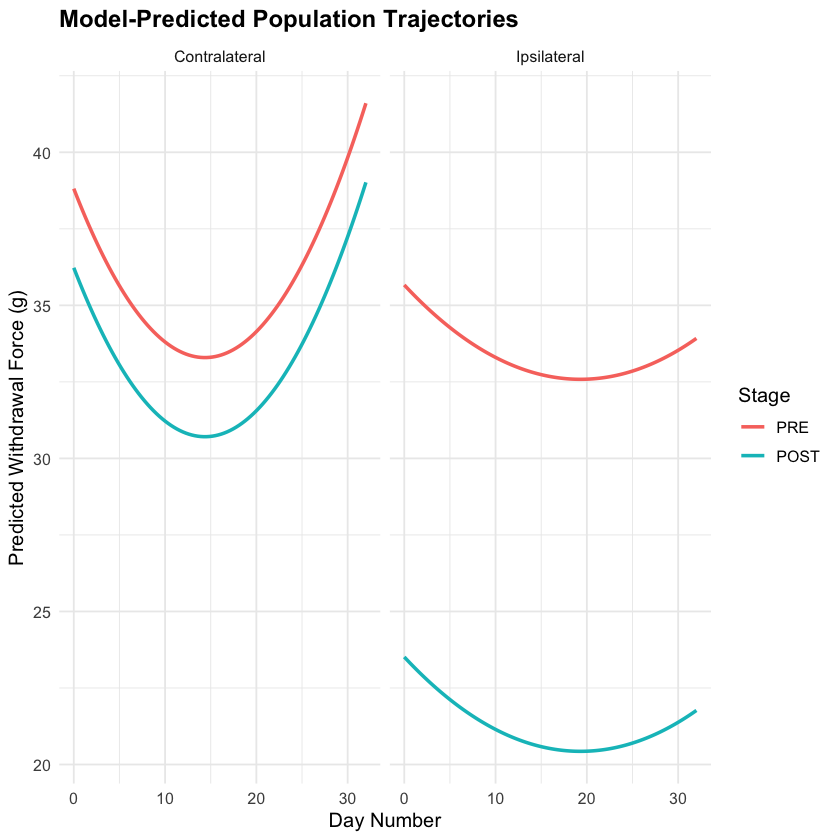

In [109]:
ggplot(grid, aes(x = DayNumber, y = Predicted, color = Stage, fill = Stage)) +
  geom_line(size = 1) +
  facet_wrap(~ Trial, labeller = as_labeller(c(C = "Contralateral", I = "Ipsilateral"))) +
  labs(
    title = "Model-Predicted Population Trajectories",
    x = "Day Number",
    y = "Predicted Withdrawal Force (g)"
  ) +
  theme_minimal() +
  theme(
    text = element_text(size = 12),
    plot.title = element_text(face = "bold")
  )


In [116]:
m5

Linear mixed model fit by REML ['lmerMod']
Formula: 
Force ~ poly(DayNumber_z, 2, raw = TRUE) * Stage * Trial + (DayNumber_z |  
    ID)
   Data: vf
REML criterion at convergence: 19069.13
Random effects:
 Groups   Name        Std.Dev. Corr 
 ID       (Intercept)  5.142        
          DayNumber_z  2.552   -0.76
 Residual             13.654        
Number of obs: 2358, groups:  ID, 18
Fixed Effects:
                             (Intercept)  
                                 31.0648  
       poly(DayNumber_z, 2, raw = TRUE)1  
                                 -1.4754  
       poly(DayNumber_z, 2, raw = TRUE)2  
                                  1.5283  
                                StagePRE  
                                  2.5845  
                                  TrialI  
                                -10.0252  
poly(DayNumber_z, 2, raw = TRUE)1:TrialI  
                                  0.4015  
poly(DayNumber_z, 2, raw = TRUE)2:TrialI  
                                 -1.

In [127]:
by_rat_day = vf %>%
  filter(Trial %in% c("I","C")) %>%
  group_by(ID, Trial, DayNumber) %>%
  summarise(MeanForce = mean(Force, na.rm = TRUE), .groups = "drop")

# Wide
wide_diff = by_rat_day %>%
  pivot_wider(names_from = Trial, values_from = MeanForce) %>%
  mutate(Diff_I_minus_C = I - C)

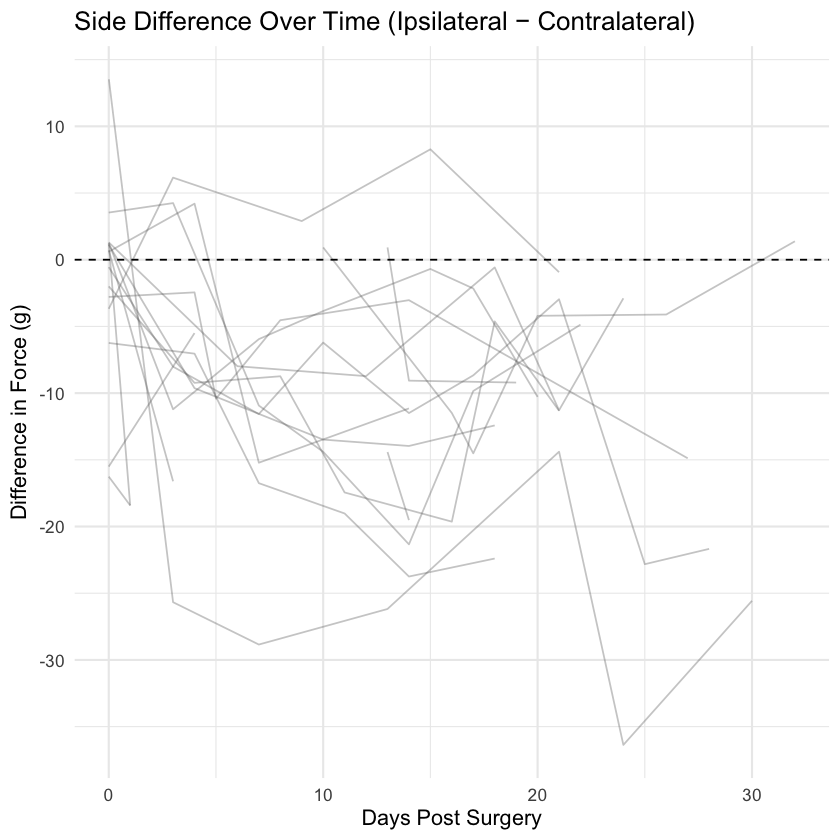

In [128]:
ggplot(wide_diff, aes(x = DayNumber, y = Diff_I_minus_C, group = ID)) +
  geom_line(alpha = 0.35, color = "gray40") +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(
    title = "Side Difference Over Time (Ipsilateral − Contralateral)",
    x = "Days Post Surgery",
    y = "Difference in Force (g)"
  ) +
  theme_minimal(base_size = 13)


In [129]:
# Step 1: Create prediction grid with all subject IDs
grid4 = expand.grid(
  DayNumber_z = seq(min(vf$DayNumber_z), max(vf$DayNumber_z), length.out = 100),
  Trial = c("I", "C"),
  Stage = c("PRE", "POST"),
  ID = unique(vf$ID)
)

# Add regular DayNumber for x-axis
day_mean = mean(vf$DayNumber, na.rm = TRUE)
day_sd   = sd(vf$DayNumber, na.rm = TRUE)
grid4$DayNumber = grid4$DayNumber_z * day_sd + day_mean


In [130]:
grid4$pred = predict(m5, newdata = grid4, re.form = NULL)

In [131]:
grid_diff = pivot_wider(grid4,
  id_cols = c("DayNumber", "Stage", "ID"),
  names_from = Trial,
  values_from = pred
)

# Calculate predicted difference (I - C)
grid_diff = grid_diff %>%
  mutate(pred_diff = I - C)


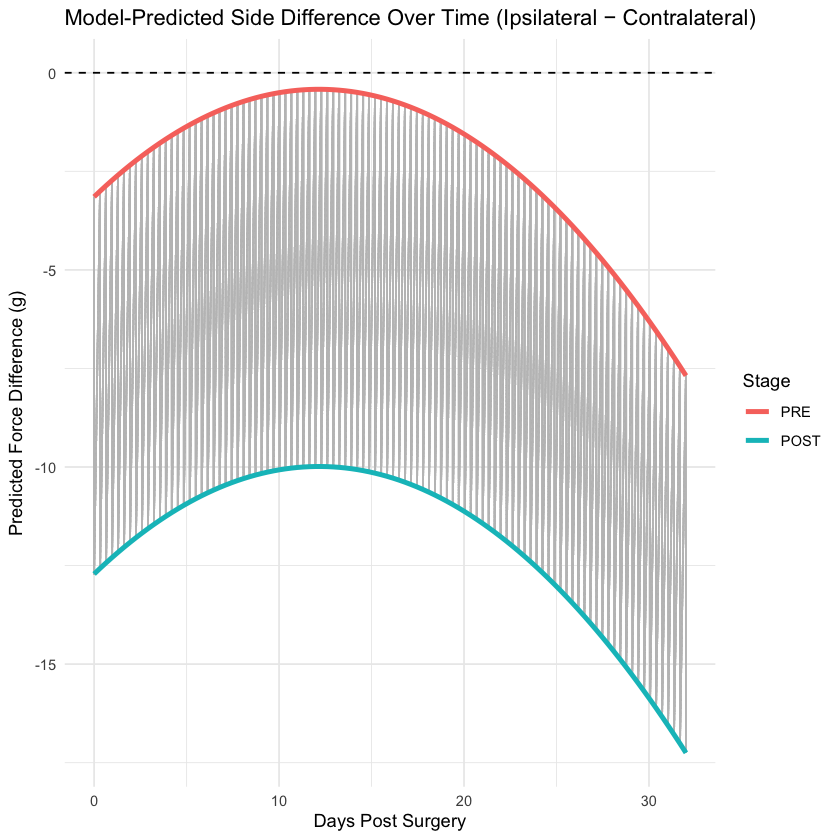

In [132]:
ggplot(grid_diff, aes(x = DayNumber, y = pred_diff, group = ID)) +
  geom_line(alpha = 0.3, color = "gray") +
  stat_summary(aes(group = Stage, color = Stage), fun = mean, geom = "line", size = 1.4) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(
    title = "Model-Predicted Side Difference Over Time (Ipsilateral − Contralateral)",
    x = "Days Post Surgery",
    y = "Predicted Force Difference (g)"
  ) +
  scale_color_manual(values = c("PRE" = "#F8766D", "POST" = "#00BFC4")) +
  theme_minimal()

In [133]:
perday = vf%>%
filter(Trial %in% c('I' ,'C')) %>% 
group_by(Trial, DayNumber) %>% 
summarise (
    n=n(), 
    sd = sd(Force, na.rm = TRUE), 
    mean = mean(Force, na.rm =TRUE), 
    sem = sd/sqrt(n),
    .groups= 'drop'
)

`geom_smooth()` using formula = 'y ~ x'


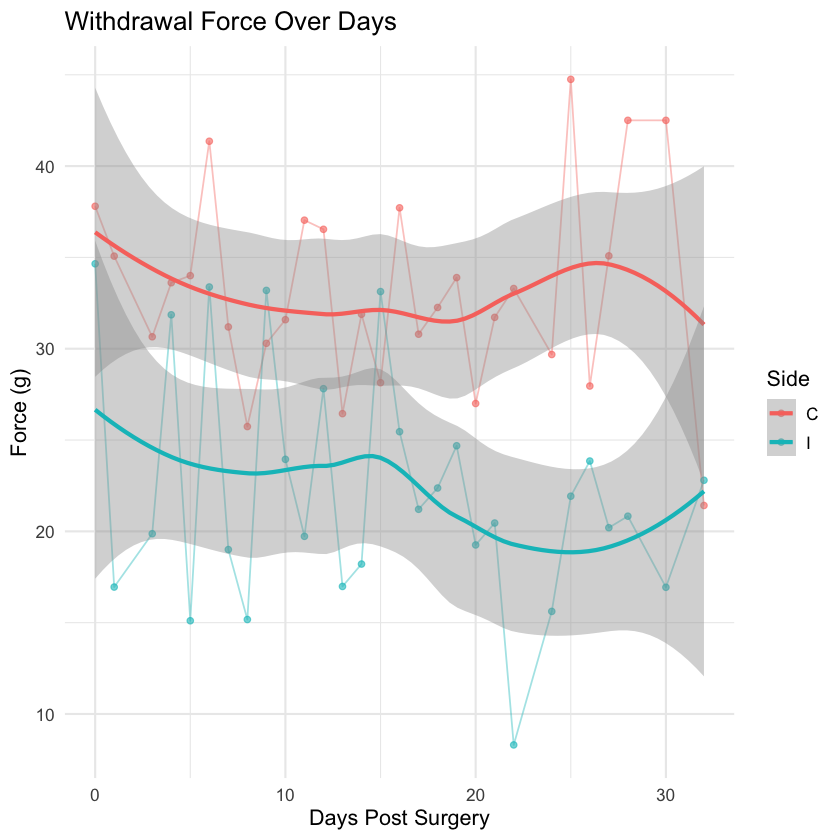

In [135]:
ggplot(perday, aes(x = DayNumber, y = mean, color = Trial, group = Trial)) +
  geom_line(alpha = 0.4) +  # faint raw lines
  geom_point(size = 1.5, alpha = 0.6) +
  geom_smooth(method = "loess", se = TRUE, linewidth = 1.2) +
  labs(
    title = "Withdrawal Force Over Days",
    x = "Days Post Surgery",
    y = "Force (g)",
    color = "Side"
  ) +
  theme_minimal(base_size = 13)

In [136]:
head(vf)

,Session,Date,Treatment,Protocol,Stage,DayNumber,Trial,ID,Latency,Reason,Scoring,Force,DayNumber_z,DayNumber_z2
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
1,1,2024-03-12 16:21:00,CCD,AMN,PRE,0,C,DW 239,0.9,Detection,Auto,33.81,-1.417452,2.009171
2,2,2024-03-12 16:22:00,CCD,AMN,PRE,0,C,DW 239,0.1,Detection,Auto,5.09,-1.417452,2.009171
3,3,2024-03-12 16:22:00,CCD,AMN,PRE,0,C,DW 239,0.8,Detection,Auto,31.31,-1.417452,2.009171
4,4,2024-03-12 16:22:00,CCD,AMN,PRE,0,I,DW 239,0.5,Detection,Auto,21.32,-1.417452,2.009171
5,5,2024-03-12 16:23:00,CCD,AMN,PRE,0,I,DW 239,2.6,Detection,Auto,75.00,-1.417452,2.009171
6,6,2024-03-12 16:23:00,CCD,AMN,PRE,0,I,DW 239,0.5,Detection,Auto,21.32,-1.417452,2.009171


In [137]:
write.csv(vf, "post_modeling_dataset.csv", row.names = TRUE)

In [139]:
m5

Linear mixed model fit by REML ['lmerMod']
Formula: 
Force ~ poly(DayNumber_z, 2, raw = TRUE) * Stage * Trial + (DayNumber_z |  
    ID)
   Data: vf
REML criterion at convergence: 19069.13
Random effects:
 Groups   Name        Std.Dev. Corr 
 ID       (Intercept)  5.142        
          DayNumber_z  2.552   -0.76
 Residual             13.654        
Number of obs: 2358, groups:  ID, 18
Fixed Effects:
                             (Intercept)  
                                 31.0648  
       poly(DayNumber_z, 2, raw = TRUE)1  
                                 -1.4754  
       poly(DayNumber_z, 2, raw = TRUE)2  
                                  1.5283  
                                StagePRE  
                                  2.5845  
                                  TrialI  
                                -10.0252  
poly(DayNumber_z, 2, raw = TRUE)1:TrialI  
                                  0.4015  
poly(DayNumber_z, 2, raw = TRUE)2:TrialI  
                                 -1.

In [140]:
m4= lmer( 
Force ~ poly(DayNumber_z, 2, raw = TRUE) * Trial + (DayNumber_z |  
    ID), 
    vf)

In [141]:
day_seq = seq(min(vf$DayNumber_z), max(vf$DayNumber_z), length.out = 100)


In [143]:
#prediction grid for m4
grid_m4 = expand.grid(
  DayNumber_z = day_seq,
  Trial = levels(vf$Trial)
)

In [144]:
day_mean = mean(vf$DayNumber, na.rm = TRUE)
day_sd = sd(vf$DayNumber, na.rm = TRUE)

grid_m4$DayNumber = grid_m4$DayNumber_z * day_sd + day_mean


In [145]:
grid_m4$predicted_force = predict(m4, newdata = grid_m4, re.form = NA)

ERROR: Error in eval(predvars, data, env): object 'Trial' not found


In [146]:
vf$Trial = as.factor(vf$Trial)

In [147]:
grid_m4 = expand.grid(
  DayNumber_z = seq(min(vf$DayNumber_z), max(vf$DayNumber_z), length.out = 100),
  Trial = levels(vf$Trial) 
)

In [148]:
grid_m4$predicted_force = predict(m4, newdata = grid_m4, re.form = NA)

In [149]:
ggplot(grid_m4, aes(x = DayNumber, y = predicted_force, color = Trial)) +
  geom_line(size = 1.2) +
  labs(
    title = "Model-Predicted Force Over Time (m4)",
    x = "Day Number",
    y = "Predicted Force (g)",
    color = "Trial Side"
  ) +
  theme_minimal()

ERROR while rich displaying an object: Error in `geom_line()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'DayNumber' not found

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 


In [150]:
grid_m4

DayNumber_z,Trial,predicted_force
<dbl>,<fct>,<dbl>
-1.4174524,C,38.22358
-1.3747067,C,37.88690
-1.3319609,C,37.55766
-1.2892151,C,37.23585
-1.2464694,C,36.92148
-1.2037236,C,36.61455
-1.1609778,C,36.31506
-1.1182321,C,36.02300
-1.0754863,C,35.73838


In [151]:
day_mean = mean(vf$DayNumber, na.rm = TRUE)
day_sd = sd(vf$DayNumber, na.rm = TRUE)

grid_m4$DayNumber = grid_m4$DayNumber_z * day_sd + day_mean


In [152]:
grid_m4

DayNumber_z,Trial,predicted_force,DayNumber
<dbl>,<fct>,<dbl>,<dbl>
-1.4174524,C,38.22358,0.0000000
-1.3747067,C,37.88690,0.3232323
-1.3319609,C,37.55766,0.6464646
-1.2892151,C,37.23585,0.9696970
-1.2464694,C,36.92148,1.2929293
-1.2037236,C,36.61455,1.6161616
-1.1609778,C,36.31506,1.9393939
-1.1182321,C,36.02300,2.2626263
-1.0754863,C,35.73838,2.5858586


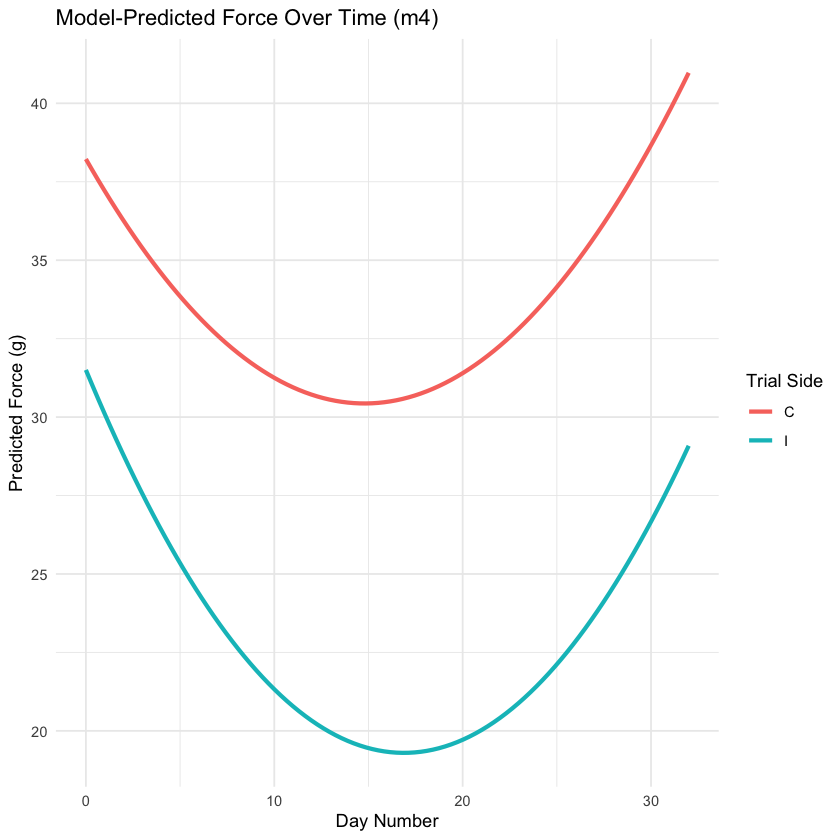

In [154]:
ggplot(grid_m4, aes(x = DayNumber, y = predicted_force, color = Trial)) +
  geom_line(size = 1.2) +
  labs(
    title = "Model-Predicted Force Over Time (m4)",
    x = "Day Number",
    y = "Predicted Force (g)",
    color = "Trial Side"
  ) +
  theme_minimal()

ggsave("m4_predictions.png", width = 7, height = 5, dpi = 300)


In [155]:
m5 = lmer(
    Force ~ Stage * Trial + (1 | ID), 
    data = vf)


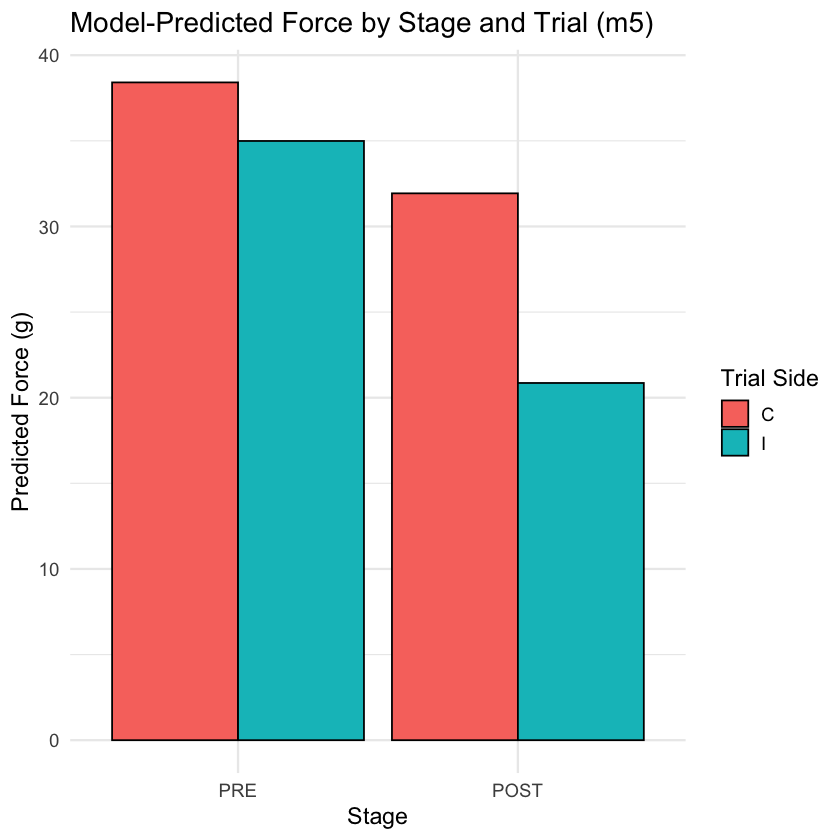

In [159]:
library(lme4)
library(ggplot2)
library(dplyr)

grid_m5 = expand.grid(
  Stage = unique(vf$Stage),
  Trial = unique(vf$Trial)
)


grid_m5$pred = predict(m5, newdata = grid_m5, re.form = NA)


ggplot(grid_m5, aes(x = Stage, y = pred, fill = Trial)) +
  geom_bar(stat = "identity", position = "dodge", color = "black") +
  labs(
    title = "Model-Predicted Force by Stage and Trial (m5)",
    x = "Stage",
    y = "Predicted Force (g)",
    fill = "Trial"
  ) +
  theme_minimal(base_size = 14)


ggsave("m5_predictions.png", width = 6, height = 4.5, dpi = 300)